In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nilearn as nil
from nilearn import plotting
import pandas as pd
import seaborn as sns
from collections import defaultdict
import joblib
from nilearn.masking import apply_mask, unmask
import nibabel as nib
plt.rcParams.update({'font.size': 18})

Bad val 'white' on line #20
	"grid.linewidth: white
"
	in file "/home/mboos/.config/matplotlib/stylelib/mb.mplstyle"
	Key grid.linewidth: Could not convert "white" to float


In [4]:
destrieux = nil.datasets.fetch_atlas_destrieux_2009()
fsavg = nil.datasets.fetch_surf_fsaverage()
fsaverage = fsavg
destrieux_surf = nil.datasets.fetch_atlas_surf_destrieux()

/home/mboos/anaconda3/envs/mne/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [5]:
destr_dict = {'lh':destrieux_surf['map_left'],
              'rh':destrieux_surf['map_right']}

ROI_map = {b'G_temp_sup-G_T_transv':"Heschl's Gyrus",
          b'G_temp_sup-Plan_tempo' : "posterior STG",
          b'G_temp_sup-Plan_polar' : "anterior STG",
           b'G_temp_sup-Lateral' : "lateral STG",
           b'S_temporal_sup' : "STS",
           b'S_temporal_transverse' : "transverse temporal sulcus"
          }
#ROI_literal_map = {destr_dict}

In [4]:
hemi='lh'
names, test_lh = zip(*[(ROI_map[destrieux_surf['labels'][i]], np.where(destr_dict[hemi]==i)[0]) for i in np.unique(destr_dict[hemi])
                         if destrieux_surf['labels'][i] in ROI_map.keys()])
hemi='rh'
names, test_rh = zip(*[(ROI_map[destrieux_surf['labels'][i]], np.where(destr_dict[hemi]==i)[0]) for i in np.unique(destr_dict[hemi])
                         if destrieux_surf['labels'][i] in ROI_map.keys()])

In [8]:
subjects = [1,2,5,6,7,8,9,11,12,14,15,16,17,18,19]

In [5]:
h_keys = ['left', 'right']
#surfmaps = {pc: {h: [nil.surface.load_surf_data(
#    'component_{0}_subj_{1:03d}_pc_coefsurf_{2}_fsavg.nii.gz'.format(pc, subj, h))
#                 for subj in subjects] for h in h_keys}
#            for pc in [1, 2, 3]}

surfmap_average = {pc: {h: -1*nil.surface.load_surf_data(
    'component_{0}_subj_001_pc_coef_averagesurf_{1}_fsavg.nii.gz'.format(pc, {'left': 'lh', 'right': 'rh'}[h])) for h in h_keys}
            for pc in [1, 2, 3]}


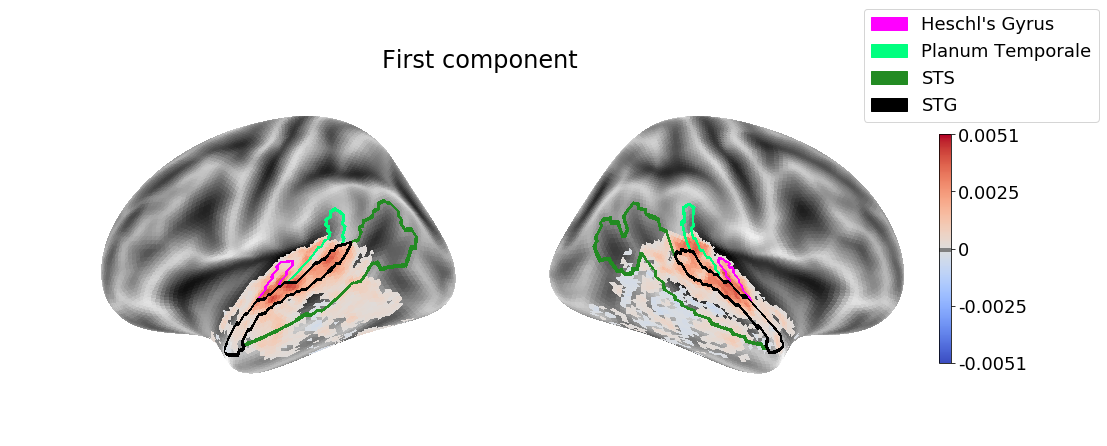

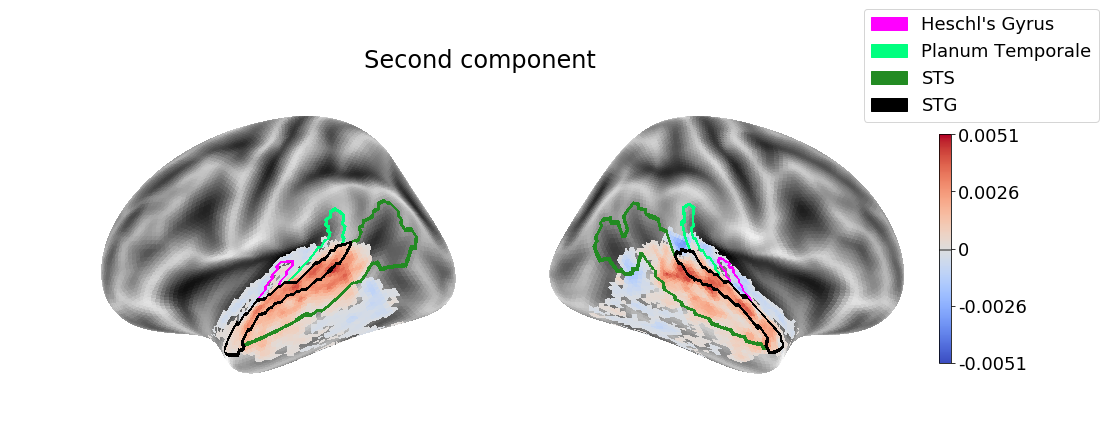

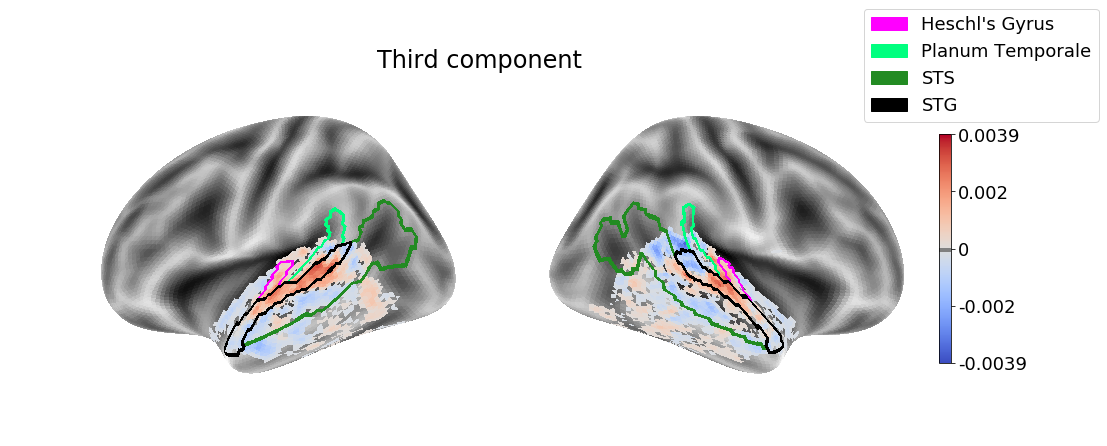

In [35]:
from nilearn.surface import load_surf_mesh
from matplotlib import colors as clr
import matplotlib.patches as mpatches
from nilearn import datasets
plt.rcParams.update({'font.size': 18})
ROI_map = {b'G_temp_sup-G_T_transv':"Heschl's Gyrus",
          b'G_temp_sup-Plan_tempo' : "Planum Temporale",
                      b'S_temporal_sup' : "STS",
           b'G_temp_sup-Lateral' : "STG"
#           'S_temporal_transverse' : "transverse temporal sulcus"
          }


regions = list(ROI_map.keys())
regions_idx = [np.where(np.array(destrieux_surf['labels'])==region)[0][0]
               for region in regions]
colors = ['magenta','springgreen', 'forestgreen', 'k']

hemi_dict = {'right': [fsavg.infl_right, fsavg.sulc_right],
            'left': [fsavg.infl_left, fsavg.sulc_left]}
labels = [lbl for lbl in ROI_map.values()]
for pc in [1, 2, 3]:
    fig, axes = plt.subplots(1, 2, subplot_kw={'projection':'3d'}, figsize=(17.5, 7))
    for j, hemi in enumerate(['left', 'right']):
        coords, faces = load_surf_mesh(fsavg['infl_{}'.format(hemi)])
        parcellation = destrieux_surf['map_{}'.format(hemi)]

        plotting.plot_surf_stat_map(hemi_dict[hemi][0], surfmap_average[pc][hemi], bg_map=hemi_dict[hemi][1], hemi=hemi, colorbar=True if hemi == 'right' else None,
                                    threshold=0.0001, cmap='coolwarm', axes=axes[j])
        plotting.plot_surf_contours(fsavg['infl_{}'.format(hemi)], parcellation, axes=axes[j], levels=regions_idx, labels=labels, legend=True if hemi=='left' else False,
                                   colors=colors)

    fig.subplots_adjust(wspace=-0.15)
    fig.suptitle('{} component'.format({1: 'First', 2: 'Second', 3: 'Third'}[pc]), fontsize=24, y=0.9)
    fig.savefig('surface_with_ROI_pc_{}.png'.format(pc), dpi=300, bbox_inches='tight', paad_inches=0.0)

In [4]:
def safe_median(scores):
    return np.nanmedian(scores[scores>0.01]) if (scores>0.01).any() else 0

def safe_perc(scores, perc=90):
    return np.percentile(scores[np.logical_and(scores>0.01,np.logical_not(np.isnan(scores)))], perc) if (scores>0.01).any() else 0.

def maps_to_mask(maps, idx):
    return nil.image.new_img_like(maps, maps.get_data()==idx)

In [34]:
from nilearn.datasets import fetch_atlas_harvard_oxford

template = fetch_atlas_harvard_oxford('cort-maxprob-thr50-1mm')
maps = nib.load(template['maps'])

In [140]:
from nilearn.masking import apply_mask
mask = maps_to_mask(maps, 21)
masked_vol = apply_mask(volmap, mask)

In [8]:
subjects = [1,2,5,6,7,8,9,11,12,14,15,16,17,18,19]
from sklearn.preprocessing import MinMaxScaler
scores = joblib.load('pc_nr_scores.pkl')
ROI_map = {'Planum Polare': 'Planum Polare',
           "Heschl's Gyrus (includes H1 and H2)": "Heschl's gyrus",
           'Superior Temporal Gyrus, anterior division': 'STG anterior',
            'Superior Temporal Gyrus, posterior division': 'STG posterior'}
maps = nib.load('harvardoxford_cort_groupbold.nii.gz')
template = joblib.load('harvard_oxford_with_labels.pkl')
all_df_list = []
for comp in [1,2,3,4,5]:
    act_dict = defaultdict(list)
    for subj_i, subj in enumerate(subjects):
        for i, region_name in enumerate(template['labels']):
            if region_name in ROI_map:
                act_dict[ROI_map[region_name]].append(
                    safe_median(apply_mask(unmask(scores[comp][subj_i], 'group_temporal_lobe_mask.nii.gz'),
                        maps_to_mask(maps, i))))
    act_dict['subject'] = subjects
    df_temp = pd.DataFrame(act_dict).melt(id_vars='subject').reset_index(drop=True)

    all_df_list.append(pd.concat([df_temp, pd.Series([comp]*df_temp.shape[0], name='Components included')], axis=1, ignore_index=True))
all_df_list = pd.concat(all_df_list)
all_df_list.columns = ['Subject', 'Region', r'median of $r$', 'Components included']

/home/mboos/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


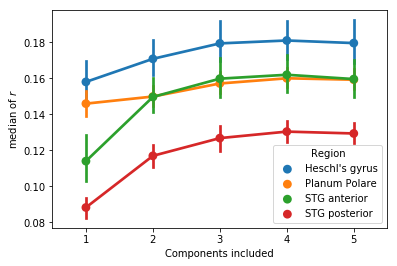

In [193]:
sns.pointplot(data=all_df_list, hue='Region', x='Components included', y=r'median of $r$', estimator=np.mean)
plt.savefig('average_increase_per_component.svg')

In [5]:
subjects = [1,2,5,6,7,8,9,11,12,14,15,16,17,18,19]
from sklearn.preprocessing import MinMaxScaler
destr_dict = {'lh':destrieux_surf['map_left'],
              'rh':destrieux_surf['map_right']}

ROI_map = {'G_temp_sup-G_T_transv':"Heschl's Gyrus",
          'G_temp_sup-Plan_tempo' : "Planum Temporale",
#          'G_temp_sup-Plan_polar' : "Planum Polare",
           'G_temp_sup-Lateral' : "STG",
           'S_temporal_sup' : "STS",
#           'S_temporal_transverse' : "transverse temporal sulcus"
          }

all_df_list = []
for comp in [1,2,3,4,5]:
    subj_dfs = []
    for subj_i, subj in enumerate(subjects):
        comp_act_on_surf = []
        for hemi in ['lh', 'rh']:
            surfmap = nil.surface.load_surf_data('component_{0}_subj_{1:03d}_pc_nr_inclsurf_{2}_fsavg.nii.gz'.format(
            comp, subj, hemi))
            act_surf_dict = {ROI_map[destrieux_surf['labels'][i]] : pd.Series(safe_perc(surfmap[destr_dict[hemi]==i], 75)) for i in np.unique(destr_dict[hemi])
                             if destrieux_surf['labels'][i] in ROI_map.keys()}
            df_temp = pd.DataFrame(act_surf_dict).melt().reset_index(drop=True)
            comp_act_on_surf.append(pd.concat([df_temp, pd.Series([{'lh':'left', 'rh':'right'}[hemi]]*df_temp.shape[0], name='Hemisphere'),
                                              pd.Series([subj_i+1]*df_temp.shape[0], name='Participant')],
                                             axis=1, ignore_index=True))
        both_hemispheres_df = pd.concat(comp_act_on_surf).reset_index(drop=True)
        all_df_list.append(pd.concat([both_hemispheres_df, pd.Series([comp]*both_hemispheres_df.shape[0], name='Component')], axis=1, ignore_index=True))
all_df_list = pd.concat(all_df_list)
all_df_list.columns = ['Region', r'75 percentile of $r$ in region', 'Hemisphere', 'Participant', 'Dimensionality']

/home/mboos/anaconda2/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [75]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
all_df_list.columns = ['Region', 'score', 'Hemisphere', 'Participant', 'Dimensionality']
md = smf.mixedlm('score ~ Dimensionality', all_df_list[all_df_list['Region']=="Heschl's Gyrus"], groups=all_df_list[all_df_list['Region']=="Heschl's Gyrus"]["Participant"])
mdf = md.fit()

/home/mboos/anaconda2/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


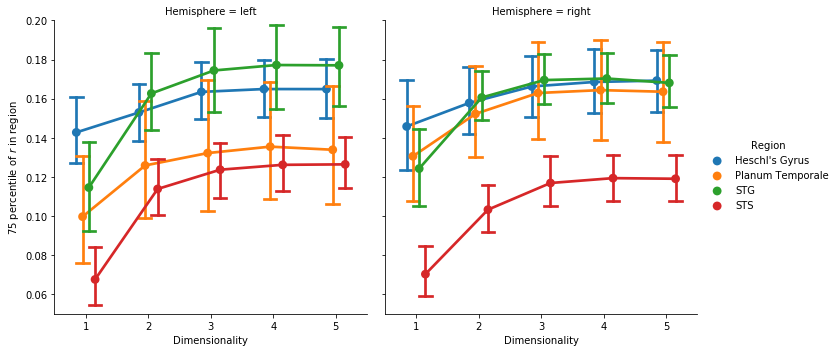

In [25]:
g=sns.catplot(data=all_df_list, hue='Region', x='Dimensionality', col='Hemisphere', y=r'75 percentile of $r$ in region', kind='point',dodge=0.3,capsize=0.2)
g.set(ylim=(0.05,0.2))
plt.savefig('r_increase_per_dimension_within.svg')

In [35]:
from sklearn.preprocessing import MinMaxScaler
destr_dict = {'lh':destrieux_surf['map_left'],
              'rh':destrieux_surf['map_right']}

ROI_map = {'G_temp_sup-G_T_transv':"Heschl's Gyrus",
          'G_temp_sup-Plan_tempo' : "Planum Temporale",
           'G_temp_sup-Lateral' : "STG",
           'S_temporal_sup' : "STS",
#           'S_temporal_transverse' : "transverse temporal sulcus"
          }

all_df_list_lo = []
for comp in [1,2,3,4,5]:
    subj_dfs = []
    for subj_i, subj in enumerate(subjects):
        comp_act_on_surf = []
        for hemi in ['lh', 'rh']:
            surfmap = nil.surface.load_surf_data('component_{0}_subj_{1:03d}_pc_nr_left_outsurf_{2}_fsavg.nii.gz'.format(
            comp, subj, hemi))
            act_surf_dict = {ROI_map[destrieux_surf['labels'][i]] : pd.Series(safe_perc(surfmap[destr_dict[hemi]==i], 75)) for i in np.unique(destr_dict[hemi])
                             if destrieux_surf['labels'][i] in ROI_map.keys()}
            df_temp = pd.DataFrame(act_surf_dict).melt().reset_index(drop=True)
            comp_act_on_surf.append(pd.concat([df_temp, pd.Series([{'lh':'left', 'rh':'right'}[hemi]]*df_temp.shape[0], name='Hemisphere'),
                                              pd.Series([subj_i+1]*df_temp.shape[0], name='Participant')],
                                             axis=1, ignore_index=True))
        both_hemispheres_df = pd.concat(comp_act_on_surf).reset_index(drop=True)
        all_df_list_lo.append(pd.concat([both_hemispheres_df, pd.Series([comp]*both_hemispheres_df.shape[0], name='Component')], axis=1, ignore_index=True))
all_df_list_lo = pd.concat(all_df_list_lo)
all_df_list_lo.columns = ['Region', r'75 percentile of $r$ in region', 'Hemisphere', 'Participant', 'Dimensionality']

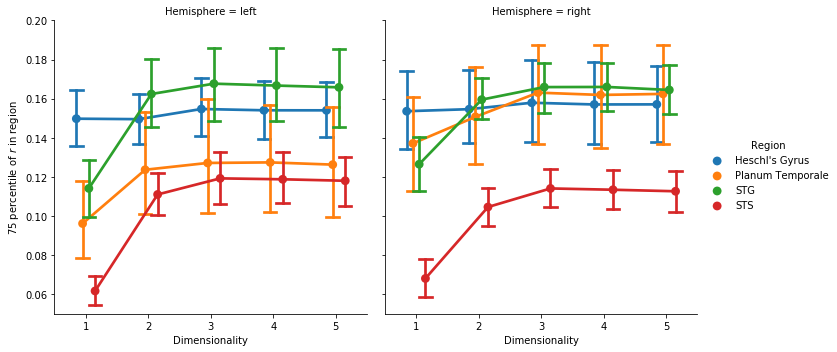

In [24]:
g = sns.catplot(data=all_df_list_lo, hue='Region', x='Dimensionality', col='Hemisphere', y=r'75 percentile of $r$ in region', kind='point',dodge=0.3,capsize=0.2)
g.set(ylim=(0.05,0.2))
plt.savefig('r_increase_per_dimension_left_out.svg')

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
all_df_list.columns = ['Region', 'score', 'Hemisphere', 'Participant', 'Dimensionality']
md = smf.mixedlm('score ~ Dimensionality', all_df_list, groups=all_df_list)
mdf = md.fit()

In [6]:
one_to_three = all_df_list[all_df_list['Dimensionality']<=3]
three_to_five = all_df_list[all_df_list['Dimensionality']>=3]
one_to_three.columns = ['Region', 'score', 'Hemisphere', 'Participant', 'Dimensionality']
three_to_five.columns = ['Region', 'score', 'Hemisphere', 'Participant', 'Dimensionality']

In [32]:
dim_one = all_df_list[all_df_list['Dimensionality']==1]

In [7]:
%load_ext rpy2.ipython

In [11]:
%%R -i one_to_three -i three_to_five
install.packages("lme4", repos='http://cran.us.r-project.org', quiet=TRUE)

/home/mboos/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: also installing the dependencies ‘minqa’, ‘nloptr’


  warnings.warn(x, RRuntimeWarning)
/home/mboos/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Updating HTML index of packages in '.Library'

  warnings.warn(x, RRuntimeWarning)
/home/mboos/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Making 'packages.html' ...
  warnings.warn(x, RRuntimeWarning)
/home/mboos/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  done

  warnings.warn(x, RRuntimeWarning)


In [38]:
new_df.columns = ['Region', 'score', 'Hemisphere', 'Participant', 'Components', 'Generalization']

In [61]:
%%R
summary(res_gen)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: score ~ (1 | Region) + (1 | Participant) + (1 | Hemisphere) +  
    (1 | Components) + Generalization
   Data: new_df

REML criterion at convergence: -4639.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.8120 -0.5832 -0.0457  0.5953  4.0448 

Random effects:
 Groups      Name        Variance  Std.Dev.
 Participant (Intercept) 4.317e-04 0.020776
 Components  (Intercept) 2.437e-04 0.015612
 Region      (Intercept) 5.747e-04 0.023973
 Hemisphere  (Intercept) 2.734e-05 0.005229
 Residual                1.125e-03 0.033545
Number of obs: 1200, groups:  
Participant, 15; Components, 5; Region, 4; Hemisphere, 2

Fixed effects:
                                  Estimate Std. Error        df t value
(Intercept)                      1.380e-01  1.539e-02 7.132e+00   8.966
GeneralizationWithin participant 4.086e-03  1.937e-03 1.176e+03   2.110
                                 Pr(>|t|)   

In [58]:
%%R -i new_df
res_gen <- lmer(score ~ (1|Region) + (1|Participant) + (1|Hemisphere) + (1|Components) + Generalization, new_df)

In [29]:
%%R -i one_to_three -i three_to_five

install.packages("lmerTest", repos='http://cran.us.r-project.org', quiet=TRUE)
library("lmerTest")
res1 <- lmer(score ~ Dimensionality + (1|Region) + (1|Participant) + (1|Hemisphere), one_to_three)
res2 <- lmer(score ~ Dimensionality + (1|Region) + (1|Participant) + (1|Hemisphere), three_to_five)

/home/mboos/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘lmerTest’


  warnings.warn(x, RRuntimeWarning)
/home/mboos/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:lme4’:

    lmer


  warnings.warn(x, RRuntimeWarning)
/home/mboos/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:stats’:

    step


  warnings.warn(x, RRuntimeWarning)


In [26]:
(0.019611-0.0008037)/np.sqrt(0.0021441**2+0.002216**2)

6.099383745800927

In [31]:
%%R
summary(res1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: score ~ Dimensionality + (1 | Region) + (1 | Participant) + (1 |  
    Hemisphere)
   Data: one_to_three

REML criterion at convergence: -1339.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6206 -0.5809 -0.0529  0.5428  3.8563 

Random effects:
 Groups      Name        Variance  Std.Dev.
 Participant (Intercept) 5.346e-04 0.023122
 Region      (Intercept) 6.289e-04 0.025078
 Hemisphere  (Intercept) 1.951e-05 0.004417
 Residual                1.179e-03 0.034333
Number of obs: 360, groups:  Participant, 15; Region, 4; Hemisphere, 2

Fixed effects:
                Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)    9.551e-02  1.502e-02 5.746e+00   6.360 0.000839 ***
Dimensionality 1.961e-02  2.216e-03 3.400e+02   8.849  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
Dimensinlty -0.2

In [24]:
%%R
summary(res)

Linear mixed model fit by REML ['lmerMod']
Formula: score ~ Dimensionality + (1 | Region) + (1 | Participant) + (1 |  
    Hemisphere)
   Data: one_to_three

REML criterion at convergence: -1339.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6206 -0.5809 -0.0529  0.5428  3.8563 

Random effects:
 Groups      Name        Variance  Std.Dev.
 Participant (Intercept) 5.346e-04 0.023122
 Region      (Intercept) 6.289e-04 0.025078
 Hemisphere  (Intercept) 1.951e-05 0.004417
 Residual                1.179e-03 0.034333
Number of obs: 360, groups:  Participant, 15; Region, 4; Hemisphere, 2

Fixed effects:
               Estimate Std. Error t value
(Intercept)    0.095511   0.015018   6.360
Dimensionality 0.019611   0.002216   8.849

Correlation of Fixed Effects:
            (Intr)
Dimensinlty -0.295


In [23]:
%%R
texreg(list(res,res2))


\begin{table}
\begin{center}
\begin{tabular}{l c c }
\hline
 & Model 1 & Model 2 \\
\hline
(Intercept)                  & $0.10^{***}$ & $0.15^{***}$ \\
                             & $(0.02)$     & $(0.02)$     \\
Dimensionality               & $0.02^{***}$ & $0.00$       \\
                             & $(0.00)$     & $(0.00)$     \\
\hline
AIC                          & -1327.07     & -1351.13     \\
BIC                          & -1303.75     & -1327.82     \\
Log Likelihood               & 669.53       & 681.57       \\
Num. obs.                    & 360          & 360          \\
Num. groups: Participant     & 15           & 15           \\
Num. groups: Region          & 4            & 4            \\
Num. groups: Hemisphere      & 2            & 2            \\
Var: Participant (Intercept) & 0.00         & 0.00         \\
Var: Region (Intercept)      & 0.00         & 0.00         \\
Var: Hemisphere (Intercept)  & 0.00         & 0.00         \\
Var: Residual                & 0.

In [36]:
new_df = pd.concat([pd.concat([all_df_list, all_df_list_lo], axis=0, ignore_index=True), pd.Series(np.repeat(['Within participant', 'Across participant'],600),name='Generalization')],axis=1)

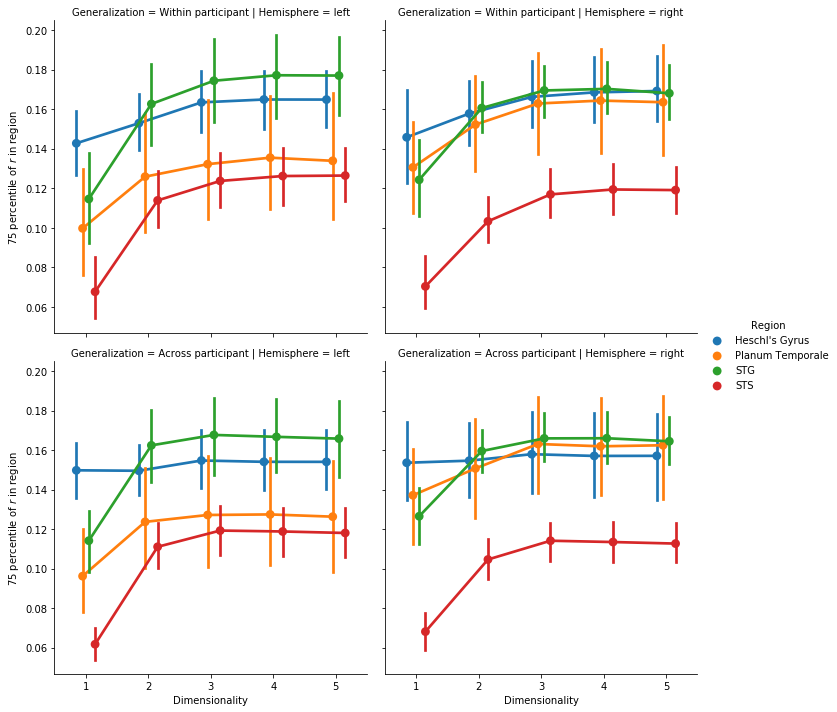

In [47]:
g = sns.catplot(data=new_df, hue='Region', x='Dimensionality', row='Generalization', units='Participant', col='Hemisphere', y=r'75 percentile of $r$ in region', kind='point',dodge=0.3)
plt.savefig('Increase_in_r_dimensionality.svg')

In [6]:
from sklearn.preprocessing import MinMaxScaler
destr_dict = {'lh':destrieux_surf['map_left'],
              'rh':destrieux_surf['map_right']}


ROI_map = {b'G_temp_sup-G_T_transv':"Heschl's Gyrus",
          b'G_temp_sup-Plan_tempo' : "Planum Temporale",
           b'G_temp_sup-Lateral' : "STG",
           b'S_temporal_sup' : "STS"
#           'S_temporal_transverse' : "transverse temporal sulcus"
          }

all_df_list = []
for comp in [1,2,3]:
    comp_act_on_surf = []
    for hemi in ['lh', 'rh']:
        surfmap = nil.surface.load_surf_data('component_{}_subj_001_pc_coef_averagesurf_{}_fsavg.nii.gz'.format(
        comp, hemi))
        act_surf_dict = {ROI_map[destrieux_surf['labels'][i]] : -1*pd.Series(surfmap[destr_dict[hemi]==i]) for i in np.unique(destr_dict[hemi])
                         if destrieux_surf['labels'][i] in ROI_map.keys()}
        df_temp = pd.DataFrame(act_surf_dict).melt().reset_index(drop=True)
        comp_act_on_surf.append(pd.concat([df_temp, pd.Series([{'lh':'left', 'rh':'right'}[hemi]]*df_temp.shape[0], name='Hemisphere')],
                                         axis=1, ignore_index=True))
    both_hemispheres_df = pd.concat(comp_act_on_surf).reset_index(drop=True)
    all_df_list.append(pd.concat([both_hemispheres_df, pd.Series([comp]*both_hemispheres_df.shape[0], name='Component')], axis=1, ignore_index=True))
all_df_list = pd.concat(all_df_list)
all_df_list.columns = ['Region', r'average PC weight', 'Hemisphere', 'Component']
all_df_list = all_df_list.dropna()

In [64]:
from scipy.stats import ttest_ind
res_dict = {}
for cmp, cmp_group in all_df_list.groupby('Component'):
    res_dict[cmp] = {}
    for reg, reg_group in cmp_group.groupby('Region'):
        res_dict[cmp][reg] = (ttest_ind(reg_group[reg_group['Hemisphere']=='left'][r'average PC weight'],
                                      reg_group[reg_group['Hemisphere']=='right'][r'average PC weight']),
                              reg_group[reg_group['Hemisphere']=='left'][r'average PC weight'].shape[0]-1+
                              reg_group[reg_group['Hemisphere']=='right'][r'average PC weight'].shape[0]-1)

In [62]:
pvals = [result[0].pvalue for res in res_dict.values() for result in res.values()]
from statsmodels.stats.multitest import multipletests
significant, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')
pval_map = {pval: pval_corr for pval, pval_corr in zip(pvals, pvals_corrected)}

In [67]:
pval_map[res_dict[3]['Planum Temporale'][0].pvalue]

0.033976335462032554

In [ ]:
plt.rcParams.update({'font.size': 15})
medianprops = dict(linestyle='-', linewidth=3.5)
g = sns.catplot(data=all_df_list, x=r'average PC weight', y='Region', hue='Hemisphere', order=["Heschl's Gyrus", 'Planum Temporale','STG', 'STS'][::-1],
                col='Component', kind='box', showfliers=False, medianprops=medianprops, palette='colorblind')
g.axes[0][0].vlines(0, -0.5, 3.5,color='r')
g.axes[0][0].set_title('First PC')
g.axes[0][1].vlines(0, -0.5, 3.5,color='r')
g.axes[0][1].set_title('Second PC')
g.axes[0][2].vlines(0, -0.5, 3.5,color='r')
g.axes[0][2].set_title('Third PC')
#_=g.axes[0][0].set_yticklabels(g.axes[0][0].get_yticklabels(), rotation=30)
plt.savefig('Average_PC_weights_flipped.pdf')

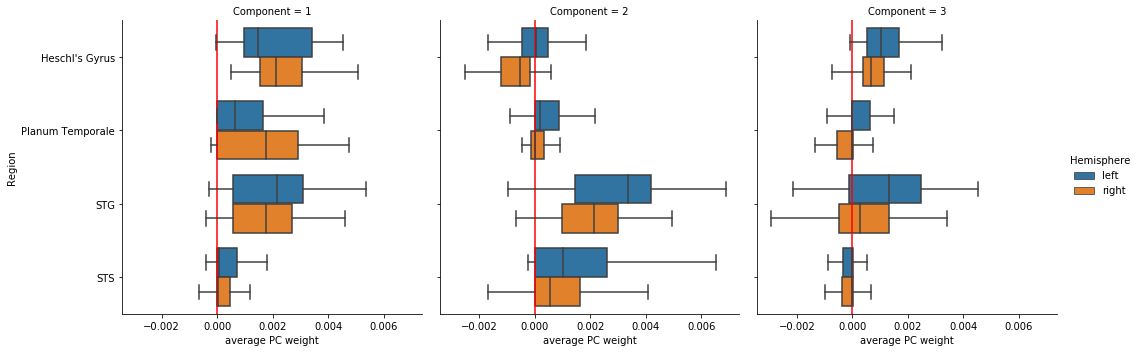

In [19]:
g = sns.catplot(data=all_df_list, x=r'average PC weight', y='Region', hue='Hemisphere', col='Component', kind='box', showfliers=False)
g.axes[0][0].vlines(0, -1, 5,color='r')
g.axes[0][1].vlines(0, -1, 5,color='r')
g.axes[0][2].vlines(0, -1, 5,color='r')
plt.savefig('Average_PC_weights.svg')